### The developed recommendation engine is a hybrid system of content and popularity based filtering as per below steps:

01. User will type a movie name s/he enjoyed

02. The recommendation engine will sort 10 movies based on content-based filtering (i.e., takes into consideration of movie   
    genres, actors, directors, language and so on)
    
03. Weighted rank scores are calculated for the 10 movies based on below formula:
     
     WR = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C

where:

    WR = weighted rank score
    R = IMDB score
    v = number of users voted
    m = 25,000 (minimum number of votes required to be listed)
    C = the mean vote across the whole report (7.21 as per this dataset)
    
04. Recommend the top five movies based on weighted rank scores

In [77]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings("ignore")

# Importing the dataset
df = pd.read_csv('F:/Python files/Movie recommender/imdb-5000-movie-dataset/imdb_5000.csv')

df.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


In [78]:
# show categorical columns
numeric_columns = list(df.describe().columns)
categorical_columns = list( set(columns) - set(numeric_columns) )
print("Categorical_columns:")
for column in categorical_columns:
    print(column)

# numeric and categorical dataframes
df_numeric = df[numeric_columns]
df_categorical = df[categorical_columns]

Categorical_columns:
language
country
content_rating
actor_1_name
plot_keywords
genres
director_name


## Create some initial plots

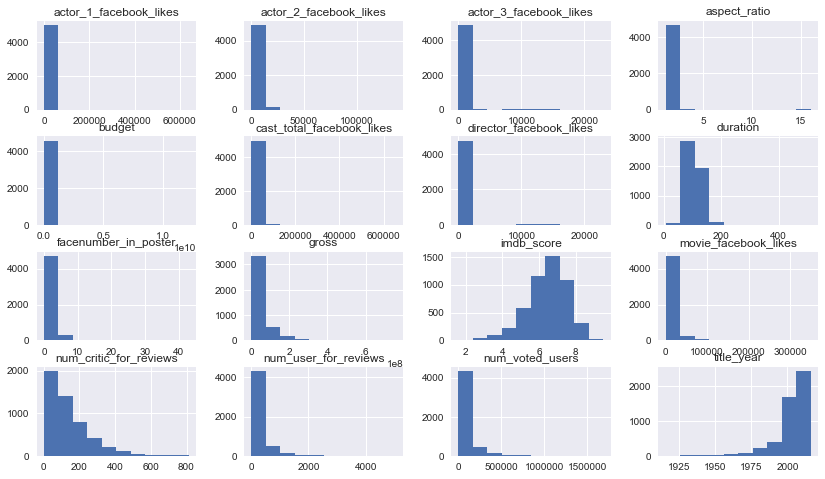

In [10]:
#01. histograms for numeric data
plt.style.use('seaborn')
df.hist(figsize=[14,8])
plt.show()

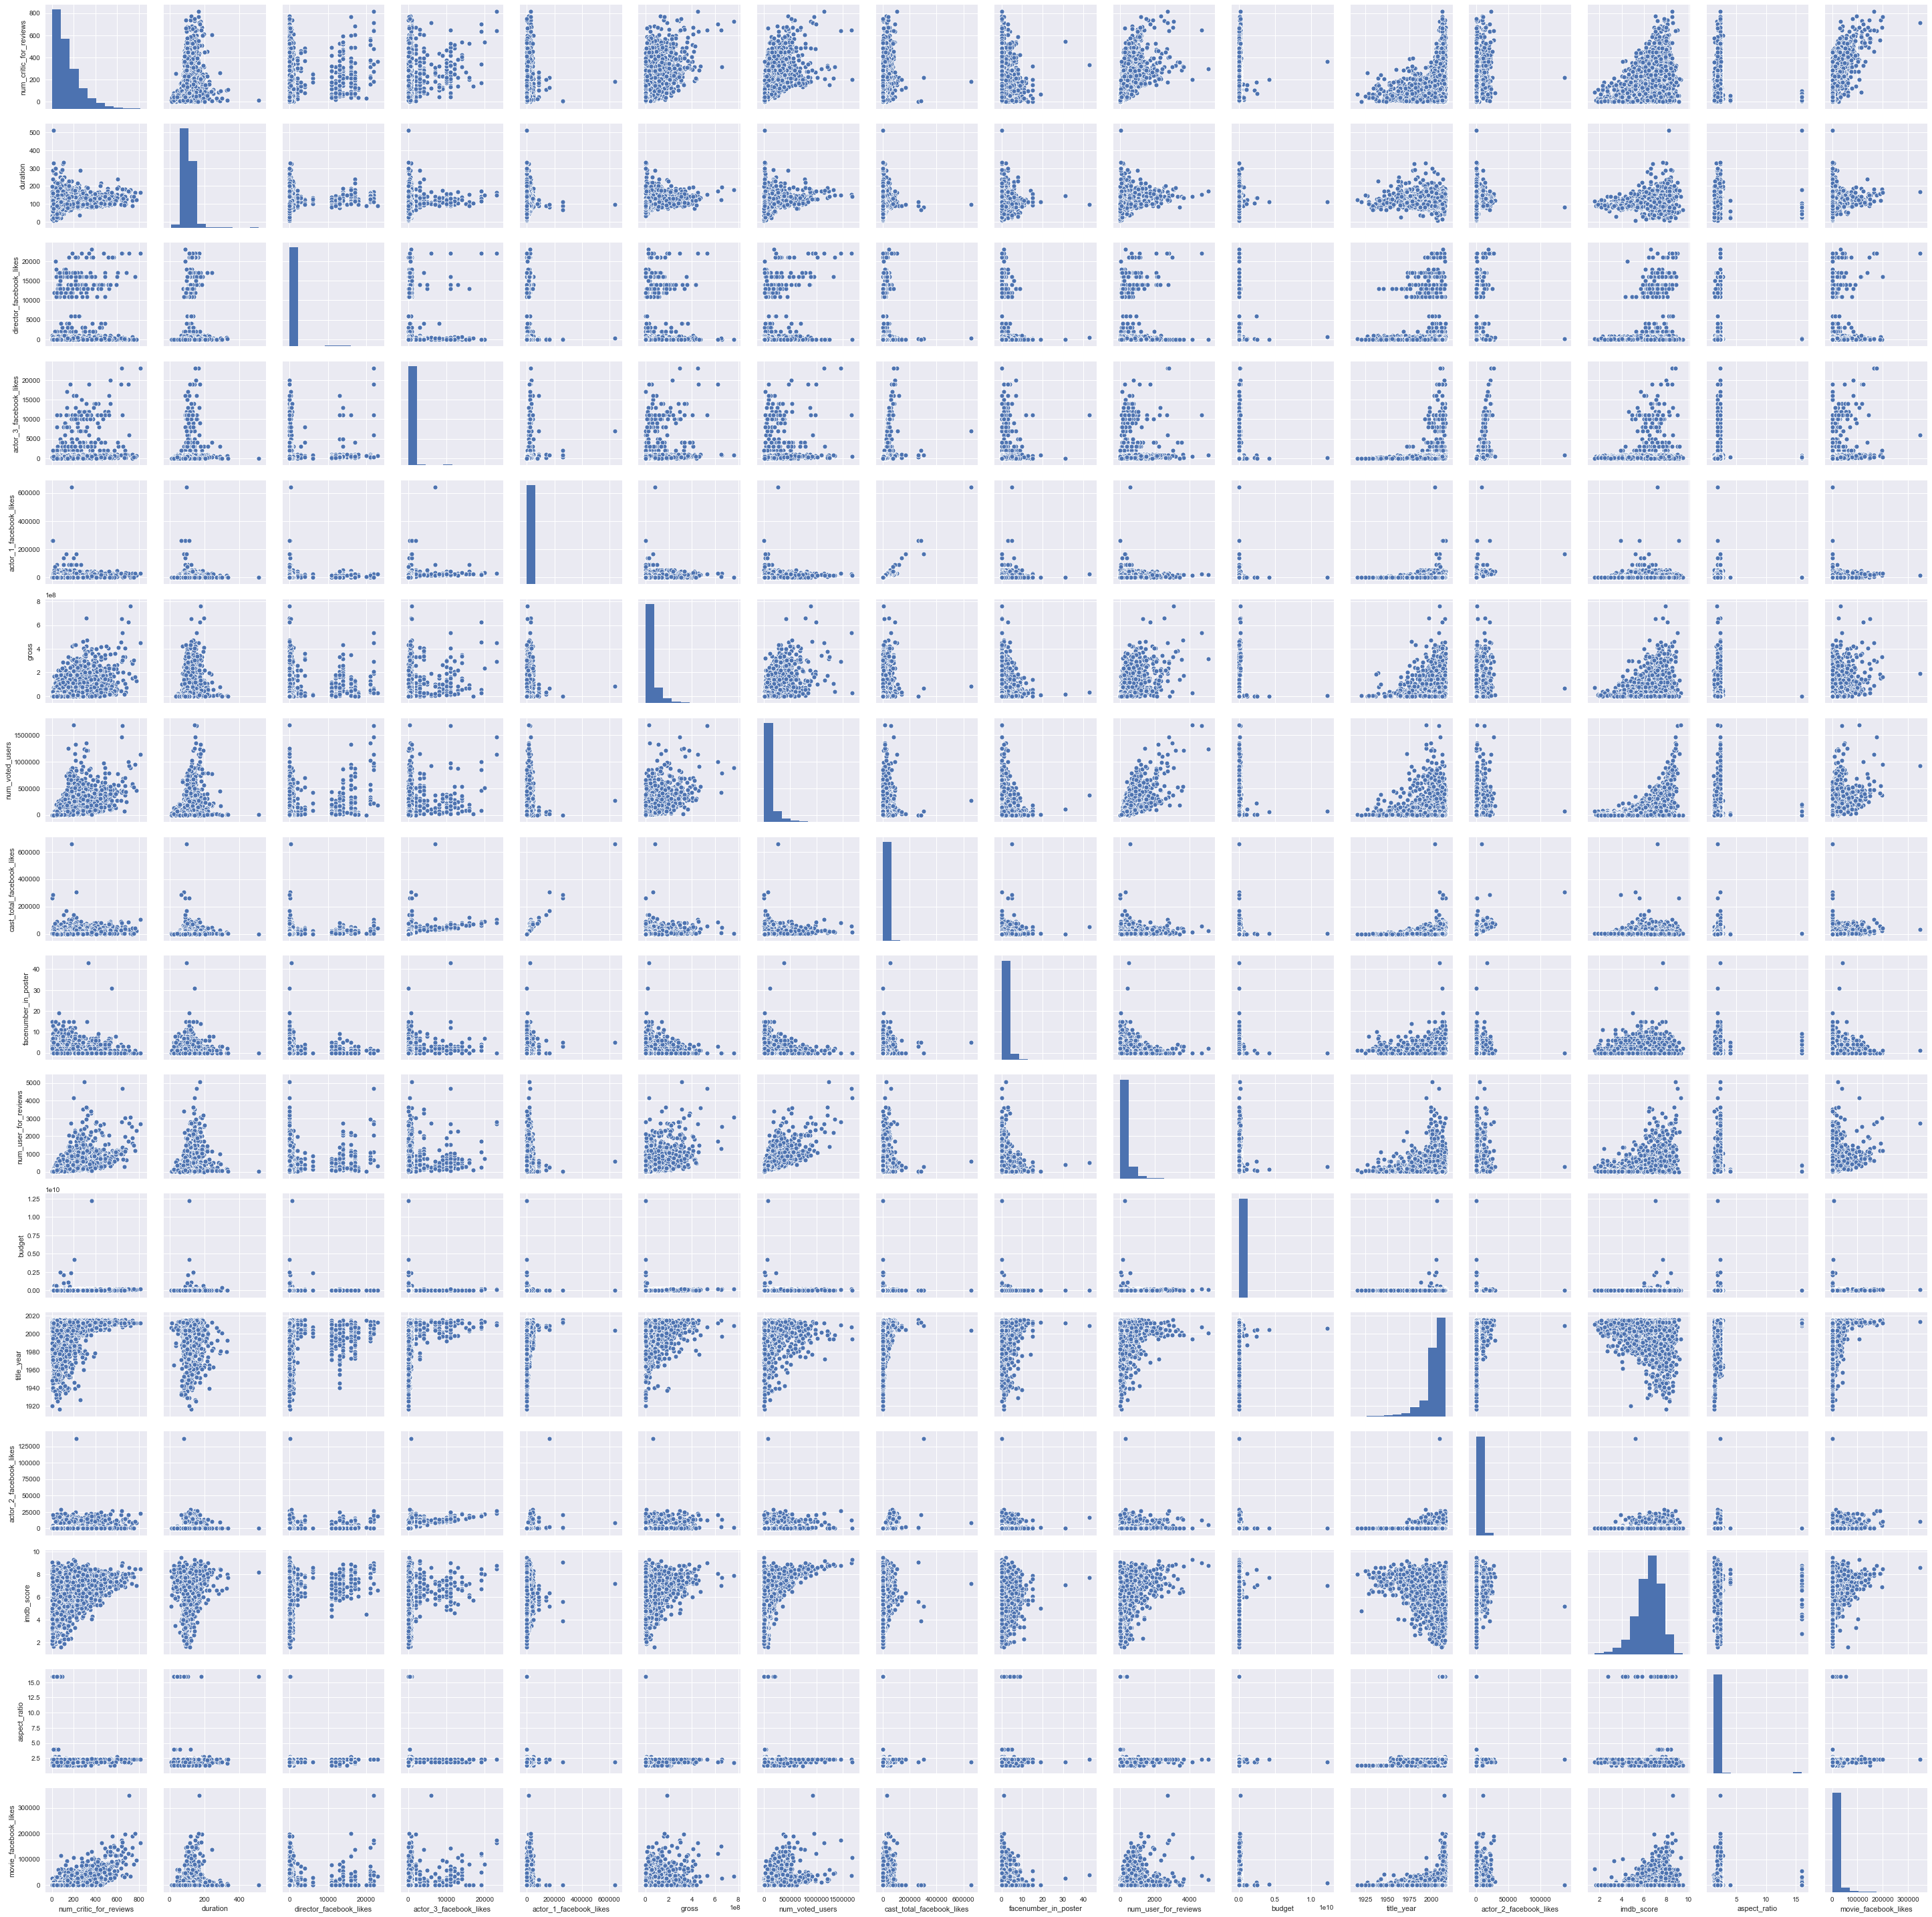

In [13]:
#02. pairplot using seaborn for the numeric data
import seaborn as sns
# sns.set(style="white", color_codes=True)
sns.pairplot(df)

Text(0.5, 1.0, 'Correlation heatmap for numeric features')

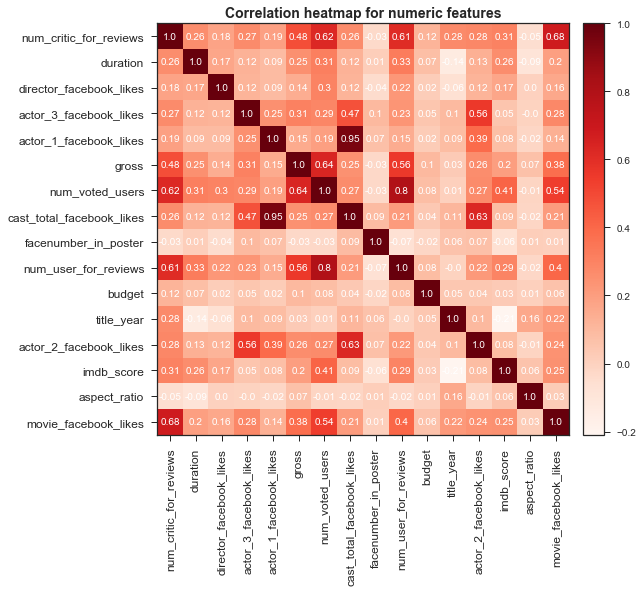

In [14]:
#03. create correlation heat-map
plt.style.use('seaborn-ticks')
from matplotlib.pyplot import cm
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(8,8))
gs = GridSpec(1, 1, figure=fig)
X = df_numeric
ax1 = fig.add_subplot(gs[0, 0])
im = ax1.imshow(X.corr(), cmap=cm.Reds)

ax1.set_xticks(range(len(X.columns)))
ax1.set_xticklabels(X.columns.values.tolist(), size=12)
for label in ax1.get_xmajorticklabels():
    label.set_rotation(90)
    label.set_horizontalalignment("center")  # 'center', right', 'left'
    
ax1.set_yticks(range(len(X.columns)))
ax1.set_yticklabels(X.columns.values.tolist(), size=12)

# Loop over data dimensions and create text annotations.
for i in range(len(X.columns)):
    for j in range(len(X.columns)):
        text = ax1.text(j, i, df.corr().values.round(2)[i, j],
                       ha="center", va="center", color="w")

# fig.colorbar(im, ax=ax1, fraction=0.046, pad=0.04)
from mpl_toolkits.axes_grid1 import make_axes_locatable

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.2 inch.
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.2)
fig.colorbar(im, cax=cax)

ax1.set_title('Correlation heatmap for numeric features', fontweight="bold", fontsize=14)

# Data cleaning

In [79]:
# drop some of the columns those I don't want to include
# the below columns, e.g., facebook likes, are mostly applicables for movies released after facebook launch. 
#Some of the other columns have the same underlying information as IMDB votes
df.drop(columns=['num_critic_for_reviews','director_facebook_likes', 'actor_3_facebook_likes', 'actor_1_facebook_likes', 'gross', 'cast_total_facebook_likes', 'actor_3_name', 'facenumber_in_poster', 'movie_imdb_link', 'num_user_for_reviews', 'country', 'budget', 'actor_2_facebook_likes', 'aspect_ratio', 'movie_facebook_likes'], inplace=True)
df['color'].value_counts()
df.drop(columns=['color'], inplace=True)
# reset the index
df.reset_index(drop=True, inplace=True)

# show the percentage of missing values
df_missing_stat = df.isnull().sum().reset_index()
# set column names
df_missing_stat.columns = ['Column title', 'Missing value count']
# add a column for missing value in percentage
df_missing_stat['Missing value in percentage'] = df_missing_stat['Missing value count']/len(df)*100
# print(df_missing_stat)
df_missing_stat.head(len(df_missing_stat))

,Column title,Missing value count,Missing value in percentage
0,director_name,104,2.062265
1,duration,15,0.297442
2,actor_2_name,13,0.257783
3,genres,0,0.000000
4,actor_1_name,7,0.138806
5,movie_title,0,0.000000
6,num_voted_users,0,0.000000
7,plot_keywords,153,3.033908
8,language,12,0.237954
9,content_rating,303,6.008328


In [80]:
# fill numeric column nan values with mean
mean = df[['duration', 'title_year']].mean().astype(int)
df[['duration', 'title_year']] = df[['duration', 'title_year']].fillna(mean)

# fill rest of the columns (categorical) nan values with 'others'
df.fillna('unknown', inplace=True)

# show descriptive stats for the numerical data
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
duration,5043.0,107.200476,25.159934,7.0,93.0,103.0,118.0,511.0
num_voted_users,5043.0,83668.160817,138485.256806,5.0,8593.5,34359.0,96309.0,1689764.0
title_year,5043.0,2002.460440,12.340460,1916.0,1999.0,2005.0,2011.0,2016.0
imdb_score,5043.0,6.442138,1.125116,1.6,5.8,6.6,7.2,9.5


In [81]:
# check duplicate movie titles
df_duplicate = df[df.duplicated(['movie_title'], keep=False)].sort_values(by = ['movie_title'])
df_duplicate.head()

,director_name,duration,actor_2_name,genres,actor_1_name,movie_title,num_voted_users,plot_keywords,language,content_rating,title_year,imdb_score
3711,Richard Fleischer,127.0,Robert J. Wilke,Adventure|Drama|Family|Fantasy|Sci-Fi,James Mason,"20,000 Leagues Under the Sea",22123,captain|expedition|sea|submarine|whale,English,Approved,1954.0,7.2
4894,Richard Fleischer,127.0,Robert J. Wilke,Adventure|Drama|Family|Fantasy|Sci-Fi,James Mason,"20,000 Leagues Under the Sea",22124,captain|expedition|sea|submarine|whale,English,Approved,1954.0,7.2
4950,David Hewlett,88.0,David Hewlett,Comedy,Christopher Judge,A Dog's Breakfast,3262,dog|vegetarian,English,unknown,2007.0,7.0
4949,David Hewlett,88.0,David Hewlett,Comedy,Christopher Judge,A Dog's Breakfast,3262,dog|vegetarian,English,unknown,2007.0,7.0
1420,Wes Craven,101.0,Lin Shaye,Horror,Johnny Depp,A Nightmare on Elm Street,149285,freddy krueger|lucid dream|serial killer|slash...,English,X,1984.0,7.5


In [82]:
# remove the duplicate movie titles
df.drop_duplicates(subset=['movie_title'], keep='first', inplace=True)
# reset the index
df.reset_index(drop=True, inplace=True)

## word cloud for categorical features

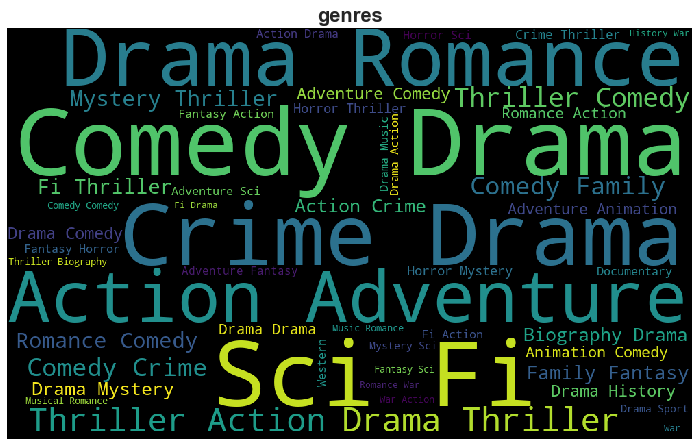

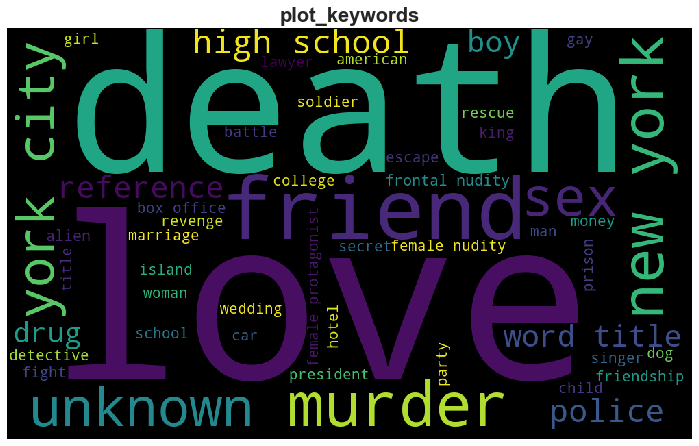

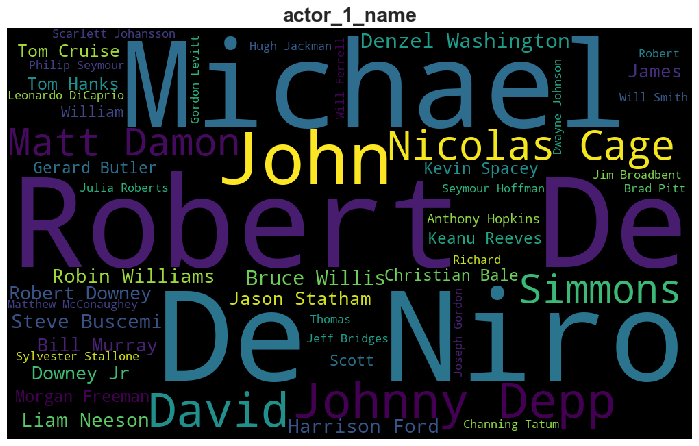

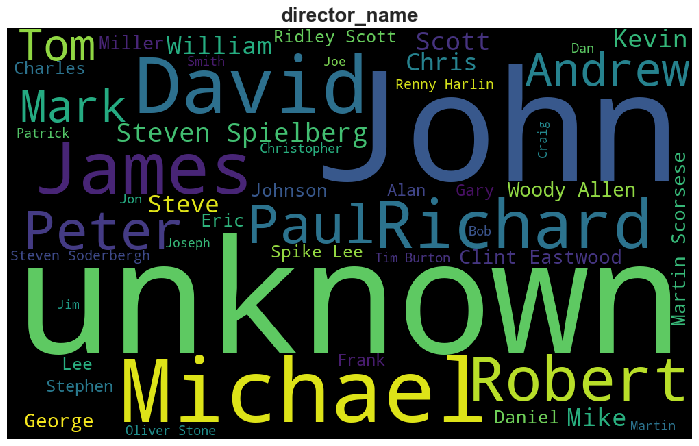

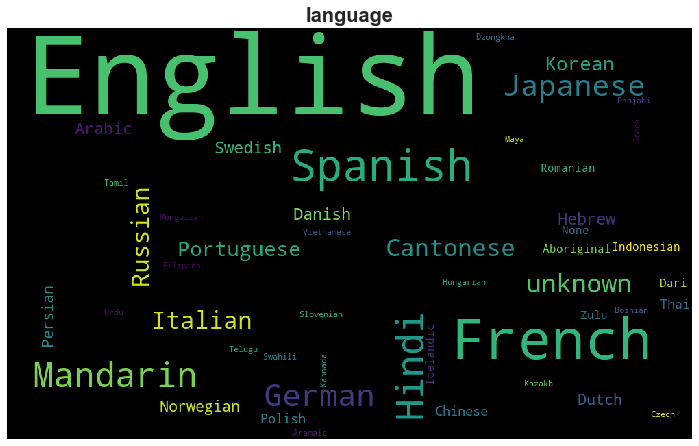

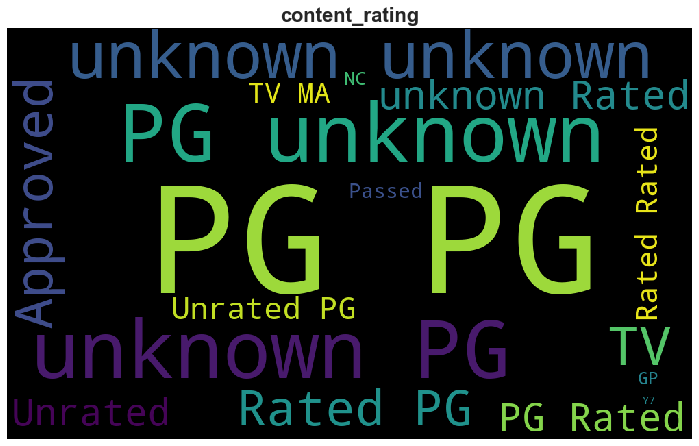

In [83]:
# create wordcloud for some of the important categorical columns
from wordcloud import WordCloud, STOPWORDS

#01. create a function which will accumulate all the words to form a very big sentence/text
def generate_text(df_column):
    '''
    parameters:
            df_column: particulat column of the df for which we want to perform one-hot coding

    return: 
            single sentence containing all the words
    '''
    column = list(df_column)
    
    # remove '|' from the elements of the columns
    column = [x.replace('|', ' ') for x in column]
    #create empty string
    text = ''
    for row in column:
        text = row + ' ' + text
    return text

#02. create wordcloud for the target columns
columns = ['genres', 'plot_keywords', 'actor_1_name', 'director_name', 'language', 'content_rating']
for column in columns:
    # create text for wordcloud
    text = generate_text(df[column])

    wordcloud = WordCloud(width = 1000, height = 600, 
                    background_color ='black',
                    max_words = 50,
#                     stopwords = STOPWORDS,
                    min_font_size = 10)

    wordcloud.generate(text)
    # plot the WordCloud image                        
    plt.figure(figsize = (10, 6), facecolor = None)
    plt.title(column, fontsize=20, fontweight='bold')
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()

## data preprocessing and more

In [46]:
'''
# create weighted rank column
We will create a new column 'weighted rank' of a movie as per below formula. IMDB follows 
the below formula for ranking their movies
ref: https://help.imdb.com/article/imdb/track-movies-tv/ratings-faq/G67Y87TFYYP6TWAV#

weighted rank (WR) = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C
 where:
  R = 'imdb_score'
  v = 'num_voted_users'
  m = 25,000 #minimum number of votes required to be listed
  C = the mean vote across the whole report (7.21 as per this dataset)
'''

r_column = df['imdb_score']
m = 25000
c = df['num_voted_users'].dot(df['imdb_score'])/df['num_voted_users'].sum()
for idx, value in enumerate(r_column):
    r = value
    v = df['num_voted_users'][idx]
    wr = (v/(v+m))*r + (m/(v+m))*c
    df.loc[idx, 'weighted_rank'] = wr

#drop 'imdb_score' and 'num_voted_users' columns
df.drop(columns = ['imdb_score', 'num_voted_users'], inplace= True)
df.head()

,director_name,duration,actor_2_name,genres,actor_1_name,movie_title,plot_keywords,language,content_rating,title_year,weighted_rank
0,James Cameron,178.0,Joel David Moore,Action|Adventure|Fantasy|Sci-Fi,CCH Pounder,Avatar,avatar|future|marine|native|paraplegic,English,PG-13,2009.0,7.881227
1,Gore Verbinski,169.0,Orlando Bloom,Action|Adventure|Fantasy,Johnny Depp,Pirates of the Caribbean: At World's End,goddess|marriage ceremony|marriage proposal|pi...,English,PG-13,2007.0,7.105832
2,Sam Mendes,148.0,Rory Kinnear,Action|Adventure|Thriller,Christoph Waltz,Spectre,bomb|espionage|sequel|spy|terrorist,English,PG-13,2015.0,6.834547
3,Christopher Nolan,164.0,Christian Bale,Action|Thriller,Tom Hardy,The Dark Knight Rises,deception|imprisonment|lawlessness|police offi...,English,PG-13,2012.0,8.472543
4,Doug Walker,107.0,Rob Walker,Documentary,Doug Walker,Star Wars: Episode VII - The Force Awakens ...,unknown,unknown,unknown,2002.0,7.215726


In [48]:
# one-hot encoding for the columns 'genres' and 'plot_keywords'
## create a function which will one-hot encode an input column (pandas series)
# SciKit one-hot encoder can not be applied for the columns 'genres' or 'plot_keywords' 
# because of their natures because, for example, a cell of 'genres' column contains 
# multiple entries, e.g, comedy, sci-fi, drama. Therefore, the following function is developed.
def one_hot_encode(df, df_column, threshold=10, plot=False):
    '''
    parameters:
            df: main data frame,
            df_column: particulat column of the df for which we want to perform one-hot coding
            vocabulary: a set of all words available in the column
            threshold: either in percentage factor (0-1) or number of top frequent elemnts(greater than 1)
            plot: if True, a bar plot of the top frequent words will be generated
    return: 
            no. of top frequent words
            high frequency words
            frequency percentage of the high frequency words
    '''
    column = list(df_column)
    # remove '|' from the elements of the columns
    column = [x.replace('|', ' ') for x in column]
    
    # import necessary libraries
    from nltk.tokenize import word_tokenize 
    from nltk.corpus import stopwords
    from nltk.stem import PorterStemmer 
    i =0
    for row in column:
        # seperate the words and make lists
        words = word_tokenize(row)
        # remove stopwards
        sw = stopwords.words('english')
        new_list = [w for w in words if not w in sw]
        # stem words
        stemmed_list = [PorterStemmer().stem(w) for w in new_list]
        column[i] = stemmed_list
        i += 1
    
    ## get the top elements (pareto analysis)
    #01. create a mega list which will contain all the elements of the column
    mega_list = []
    for row in column:
        for word in row:
            mega_list.append(word)
    df1 = pd.DataFrame(mega_list, columns = ['mega_list'])
    
    #02. calculate frequency percentage of all the unique elements
    frequency_percent = df1['mega_list'].value_counts()/len(df1)*100
    
    #03. find the top frequent elements
    high_frequency_elements = []
    y = []
    summation = 0
    for x in list(frequency_percent.index):
        high_frequency_elements.append(x)
        y.append(frequency_percent[x])
        # if threshold in percentage
        if threshold <= 1:
            summation += (frequency_percent[x]/100)
        # if threshold not in percentage, top frequent element numbers
        else:
            summation += 1
        if summation >= threshold:
            break
    
    # plot the frequency percetage of the top elements   
    if plot == True:
        import matplotlib.pyplot as plt
        plt.bar(high_frequency_elements, y)
        plt.xticks(rotation=90)
        
    #04. perform one-hot encoding of the column
    i =0
    for row in column:
        for x in high_frequency_elements:
            col_name = f"{df_column.name}_{x}"
            if x in row:
                df.loc[i, col_name] = 1
            else:
                df.loc[i, col_name] = 0
        i += 1
    if threshold <= 1:
        return len(high_frequency_elements), high_frequency_elements, y
    else:
        return sum(y), high_frequency_elements, y

# one-hot code "genre" column
no_of_genres, genres_high_frequency_elements, genres_y = one_hot_encode(df, df['genres'], threshold=24, plot=False)
df.drop(columns=['genres'], inplace=True)
## one-hot code "plot_keywords" column
#cum_percentage, keywords_high_frequency_elements, keywords_y = one_hot_encode(df, df['plot_keywords'], threshold=10, plot=False)
#df.drop(columns=['plot_keywords'], inplace=True)
df.drop(columns=['plot_keywords'], inplace=True)

In [49]:
# perform one-hot encoding for rest of the categorical variables
def one_hot_encode(df, df_column, threshold=20, plot=False):
    '''
    parameters:
            df: main data frame,
            df_column: particulat column of the df for which we want to perform one-hot coding
            vocabulary: a set of all words available in the column
            threshold: either in percentage factor (0-1) or number of top frequent elemnts(greater than 1)
            plot: if True, a bar plot of the top frequent words will be generated
    return: 
            no. of unique words in that column
            high frequency words
            frequency percentage of the high frequency words
    '''
    
    #01. calculate frequency percentage of all the unique elements
    frequency_percent = df_column.value_counts()/len(df)*100
    
    #02. find the top frequent elements
    high_frequency_elements = []
    y = []
    summation = 0
    for x in list(frequency_percent.index):
        high_frequency_elements.append(x)
        y.append(frequency_percent[x])
        # threshold in percentage
        if threshold <= 1:
            summation += frequency_percent[x]/100
        # threshold not in percentage, top frequent element numbers
        else:
            summation += 1
        if summation >= threshold:
            break
      
    # plot the frequency percetage of the top elements   
    if plot == True:
        import matplotlib.pyplot as plt
        plt.bar(high_frequency_elements, y)
        plt.xticks(rotation=90)
        
    #03. perform one-hot encoding of the column
    i =0
    for row in df_column:
        for x in high_frequency_elements:
            col_name = f"{df_column.name}_{x}"
            if x in row:
                df.loc[i, col_name] = 1
            else:
                df.loc[i, col_name] = 0
        i += 1
    if threshold <= 1:
        return len(high_frequency_elements), high_frequency_elements, y
    else:
        return sum(y), high_frequency_elements, y

# show value counts for the below columns
target_columns = ['director_name', 'actor_1_name', 'actor_2_name', 'language', 'content_rating']
for column in target_columns:
    print(column)
    print(df[column].value_counts())
    print('\n')

# perform one-hot encoding
#cum_percentage, high_frequency_elements, percent_value = one_hot_encode(df, df['director_name'], threshold=20, plot=False)
df.drop(columns=['director_name'], inplace=True)
cum_percentage, high_frequency_elements, percent_value = one_hot_encode(df, df['actor_1_name'], threshold=20, plot=False)
df.drop(columns=['actor_1_name'], inplace=True)
cum_percentage, high_frequency_elements, percent_value = one_hot_encode(df, df['actor_2_name'], threshold=20, plot=False)
df.drop(columns=['actor_2_name'], inplace=True)
cum_percentage, high_frequency_elements, percent_value = one_hot_encode(df, df['language'], threshold=2, plot=False)
df.drop(columns=['language'], inplace=True)
# replace PG-13' with 'PG'
df['content_rating'].replace('PG-13', 'PG', inplace=True)
cum_percentage, high_frequency_elements, percent_value = one_hot_encode(df, df['content_rating'], threshold=2, plot=False)
df.drop(columns=['content_rating'], inplace=True)

director_name
unknown                 102
Steven Spielberg         26
Woody Allen              22
Martin Scorsese          20
Clint Eastwood           20
Ridley Scott             16
Spike Lee                16
Steven Soderbergh        15
Renny Harlin             15
Tim Burton               14
Oliver Stone             14
Barry Levinson           13
Robert Zemeckis          13
Ron Howard               13
Robert Rodriguez         13
Joel Schumacher          13
Michael Bay              12
Tony Scott               12
Kevin Smith              12
Brian De Palma           12
Francis Ford Coppola     11
Rob Reiner               11
Sam Raimi                11
Richard Donner           11
Chris Columbus           11
Richard Linklater        11
Shawn Levy               11
David Fincher            10
Bobby Farrelly           10
Wes Craven               10
                       ... 
Lance Kawas               1
Klaus Menzel              1
Rusty Cundieff            1
Cassandra Nicolaou        1
Alan J

In [50]:
# Save the unscaled dataframe using pickle and reload the dataset
import pickle
pickle.dump(df, open('df_before_scaling.pkl','wb'))
df_before_scaling = pickle.load(open('df_before_scaling.pkl','rb'))

In [51]:
# scale the dataset
from sklearn.preprocessing import MinMaxScaler
x1 = df_before_scaling.drop(columns=['movie_title', 'weighted_rank']).values
scaler = MinMaxScaler().fit(x1)
# numeric columns
scaled_data = scaler.transform(x1)
#pickle scaled data
pickle.dump(scaled_data, open('scaled_data.pkl','wb'))

In [52]:
# create a movie list with lower case and no space between strings
movie_list=[]
for value in df_before_scaling['movie_title'].tolist():
    name = value.strip()
    name = name.lower().replace(' ', '').replace(':', '').replace('\'', '').replace('-', '')
    movie_list.append(name)

#pickle the movie_list
pickle.dump(movie_list, open('movie_list.pkl','wb'))

# create a dataframe with columns movie_title and weighted_rank
df_name_and_weighted_rank = df_before_scaling[['movie_title', 'weighted_rank']]
#pickle df_name_and_weighted_rank
pickle.dump(df_name_and_weighted_rank, open('df_name_and_weighted_rank.pkl','wb'))

## movie recommendation engine

In [56]:
# define a function which will recommend best 'n' movies for a specific user

def recommend_movie(original_user_input, n=5):
    
    user_input = original_user_input.strip()
    user_input = user_input.lower().replace(' ', '').replace(':', '').replace('\'', '').replace('-', '')
    
    # get index of the movie from the movie_list
    movie_list = pickle.load(open('movie_list.pkl','rb'))
    idx = movie_list.index(user_input)
    
    # unpickle the scaled data
    scaled_data = pickle.load(open('scaled_data.pkl','rb'))
    
    # calculate cosine similarity for the user input movie
    similarity_matrix = cosine_similarity(scaled_data, scaled_data[idx].reshape(1, -1))
    
    # get the index of the top 10 movies similar to user_input
    # the index 0 contains the user input movie. So, we start the index from 1
    idx = list(np.argsort(-similarity_matrix.flatten())[1:11])
    
    # reload df_name_and_weighted_rank
    df_name_and_weighted_rank = pickle.load(open('df_name_and_weighted_rank.pkl','rb'))  
    df_top_10_by_type = df_name_and_weighted_rank.loc[idx]
    
    # sort the list by weighted rank and show the first 5 movies
    result = df_top_10_by_type.sort_values(by=['weighted_rank'], ascending=False)['movie_title'][:n].tolist()
    
    return result


In [76]:
## Run the recommendation engine for user input
# user input: partial or full movie name
original_user_input = 'Brave'

try:
    try:
        recommendations = recommend_movie(original_user_input)
        print(f"Since you liked {original_user_input}, our recommendations are: \n ")
        for x in recommendations:
            print(x)
    except:
        import difflib
        close_match = difflib.get_close_matches(original_user_input, movie_list, n=1)[0]
        user_input = close_match
        idx = movie_list.index(user_input)
        df_name_and_weighted_rank = pickle.load(open('df_name_and_weighted_rank.pkl','rb'))
        movie_title = df_name_and_weighted_rank.loc[idx, 'movie_title']
        print(f"Did you mean- {movie_title.strip()}? \nIf yes, our recommendations are:\n")
        recommendations = recommend_movie(close_match)
        for x in recommendations:
            print(x)
        
except:
    print("Sorry!!! The movie is not in our database. Please try another movie or keyword.")
    

Since you liked Brave, our recommendations are: 
 
The Croods 
Arthur Christmas 
ParaNorman 
The Boxtrolls 
The Good Dinosaur 
